<a href="https://colab.research.google.com/github/Anubhuti-lab/Anubhuti-lab/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copy this whole cell and run in local Python / Colab
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 0) Adjust path if needed
file_path = "/content/Online Retail.xlsx"   # change if running locally (e.g., "./Online Retail.xlsx")

# 1) Load
df = pd.read_excel(file_path, engine="openpyxl")
print("Raw rows:", df.shape[0])
print("Columns:", df.columns.tolist())

# 2) Cleaning
df = df.drop_duplicates()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # drop cancellations
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] >= 0)]
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 3) Snapshot + historical / future windows
max_date = df['InvoiceDate'].max()
snapshot_date = max_date - timedelta(days=90)
hist = df[df['InvoiceDate'] <= snapshot_date].copy()
future = df[df['InvoiceDate'] > snapshot_date].copy()

# 4) Aggregate historical features per customer
cust_agg = hist.groupby('CustomerID').agg(
    Recency_days = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('InvoiceNo', 'nunique'),
    Monetary = ('TotalPrice', 'sum'),
    AvgOrderValue = ('TotalPrice', 'mean'),
    AvgQuantity = ('Quantity', 'mean')
).reset_index()
cust_agg['CLV_approx'] = cust_agg['Monetary']

# 5) Target label: future purchase flag
future_flag = future.groupby('CustomerID').size().rename('FuturePurchaseCount').reset_index()
future_flag['FuturePurchase'] = (future_flag['FuturePurchaseCount'] > 0).astype(int)
cust_agg = cust_agg.merge(future_flag[['CustomerID','FuturePurchase']], on='CustomerID', how='left')
cust_agg['FuturePurchase'] = cust_agg['FuturePurchase'].fillna(0).astype(int)

# 6) RFM transform + scaling
rfm = cust_agg[['Recency_days','Frequency','Monetary']].copy()
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
X_rfm_model = rfm[['Recency_days','Frequency_log','Monetary_log']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfm_model)

# 7) Fast silhouette on a sample to pick k (use sample to be quick)
sample_n = min(3000, X_scaled.shape[0])
idx = np.random.choice(X_scaled.shape[0], sample_n, replace=False)
X_sample = X_scaled[idx]
sil_scores = {}
for k in range(2,7):
    km = MiniBatchKMeans(n_clusters=k, batch_size=512, random_state=42, n_init=10)
    labels = km.fit_predict(X_sample)
    sil_scores[k] = silhouette_score(X_sample, labels)
print("Silhouette (sample):", sil_scores)
best_k = max(sil_scores, key=sil_scores.get)
print("Chosen k:", best_k)

# 8) Cluster full dataset with MiniBatchKMeans (fast)
mbk = MiniBatchKMeans(n_clusters=best_k, batch_size=1000, random_state=42, n_init=20)
cust_agg['Cluster'] = mbk.fit_predict(X_scaled)

# 9) Cluster centers interpretation
centers = scaler.inverse_transform(mbk.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=['Recency_days_center','Frequency_log_center','Monetary_log_center'])
centers_df['Frequency_center'] = np.expm1(centers_df['Frequency_log_center']).round(2)
centers_df['Monetary_center'] = np.expm1(centers_df['Monetary_log_center']).round(2)
centers_df['Cluster'] = centers_df.index
print(centers_df[['Cluster','Recency_days_center','Frequency_center','Monetary_center']])

# 10) Quick cluster summary
cluster_summary = cust_agg.groupby('Cluster').agg(
    Count=('CustomerID','count'),
    Avg_Recency=('Recency_days','mean'),
    Avg_Frequency=('Frequency','mean'),
    Avg_Monetary=('Monetary','mean'),
    FuturePurchase_Rate=('FuturePurchase','mean')
).reset_index().sort_values('Cluster')
print(cluster_summary)

# 11) Predictive model (binary): will purchase in next 90d?
features = ['Recency_days','Frequency','Monetary','AvgOrderValue','AvgQuantity','CLV_approx']
X = cust_agg[features].fillna(0)
y = cust_agg['FuturePurchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# 12) Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)
fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

print("Accuracy", acc, "Precision", prec, "Recall", rec, "ROC_AUC", roc)
print("Confusion matrix:\n", cm)
print("Feature importances:\n", fi)

# 13) Save outputs
cust_agg.to_csv("customer_segments_and_labels.csv", index=False)
print("Saved file: customer_segments_and_labels.csv")

Raw rows: 541909
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Silhouette (sample): {2: np.float64(0.40756939071574183), 3: np.float64(0.367824662805134), 4: np.float64(0.34626633623860514), 5: np.float64(0.32486696218806826), 6: np.float64(0.2983284193010325)}
Chosen k: 2
   Cluster  Recency_days_center  Frequency_center  Monetary_center
0        0           141.278187              1.26           265.50
1        1            41.240619              4.62          1596.97
   Cluster  Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
0        0   1860   138.837097       1.343548    362.313134   
1        1   1510    39.854305       6.231126   3158.328617   

   FuturePurchase_Rate  
0             0.408065  
1             0.769536  
Accuracy 0.6619217081850534 Precision 0.7112068965517241 Recall 0.6860706860706861 ROC_AUC 0.728776375185215
Confusion matrix:
 [[228 134]
 [151 330]]
Feature importances:
 CLV_approx       

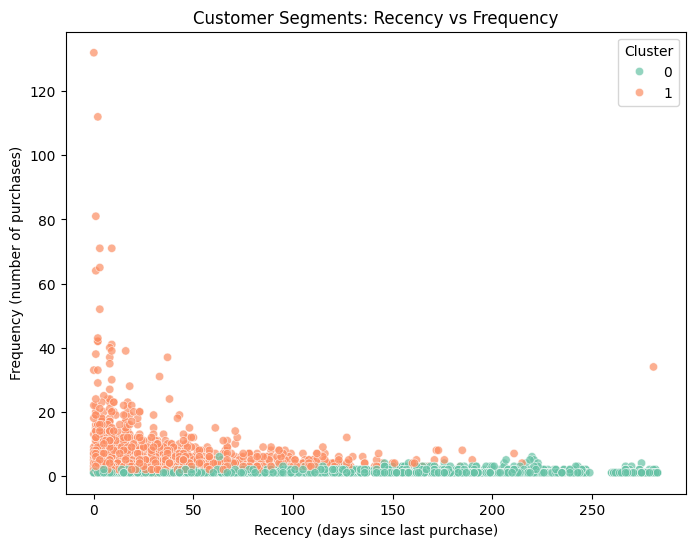

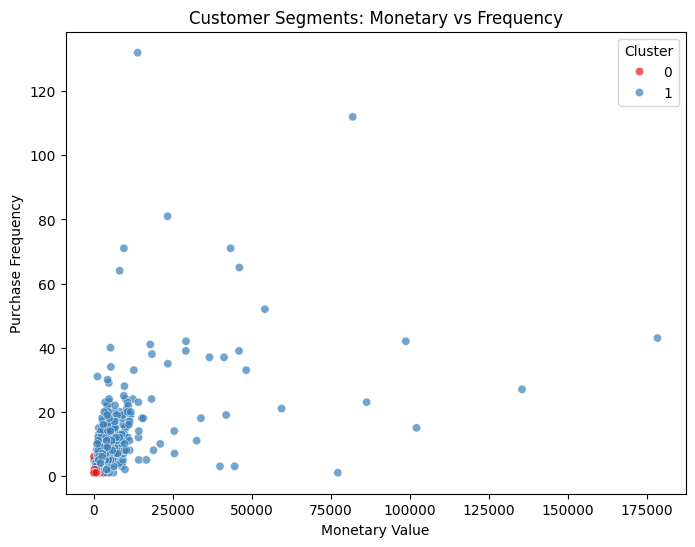

/tmp/ipython-input-2310465480.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cust_agg, x='Cluster', palette='viridis')


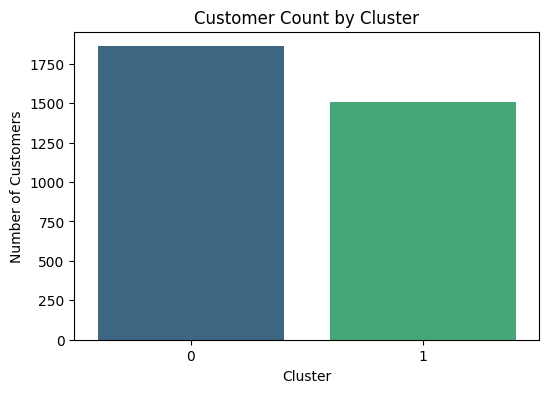

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure cust_agg has the needed columns
# Columns needed: Recency_days, Frequency, Monetary, Cluster

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=cust_agg,
    x='Recency_days',
    y='Frequency',
    hue='Cluster',
    palette='Set2',
    alpha=0.7
)
plt.title('Customer Segments: Recency vs Frequency')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (number of purchases)')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=cust_agg,
    x='Monetary',
    y='Frequency',
    hue='Cluster',
    palette='Set1',
    alpha=0.7
)
plt.title('Customer Segments: Monetary vs Frequency')
plt.xlabel('Monetary Value')
plt.ylabel('Purchase Frequency')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=cust_agg, x='Cluster', palette='viridis')
plt.title('Customer Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()
